In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('husl')
plt.style.context('ggplot')


from scipy import stats
import statsmodels.api as sm

from __future__ import division
import math

In [86]:
df_99 = pd.read_csv('Trial_99_Cleaned')
df_51 = pd.read_csv('Trial_051_Cleaned')

## The Overall Experience 

### Trial 99:



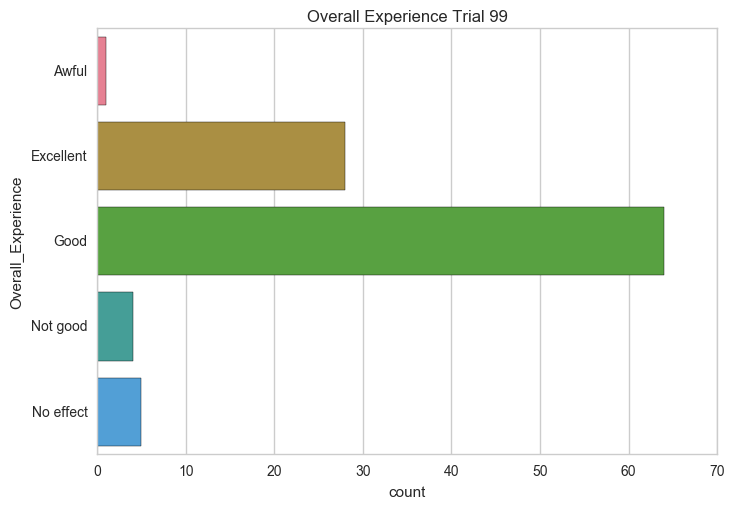

In [3]:
sns.countplot(y="Overall_Experience", data=df_99, order=['Awful', 'Excellent', 'Good', 'Not good', 'No effect'])
plt.title('Overall Experience Trial 99')


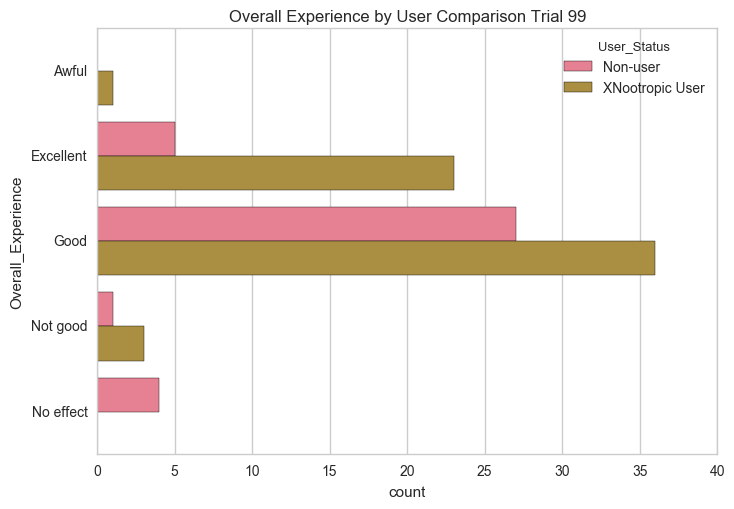

In [4]:
sns.countplot(y="Overall_Experience",hue='User_Status', data=df_99, order=['Awful', 'Excellent', 'Good', 'Not good', 'No effect'] )
plt.title('Overall Experience by User Comparison Trial 99')

In [5]:
T99_cont_table1 = pd.crosstab(index=df_99.Overall_Experience, columns=df_99.User_Status, margins=True)
T99_cont_table1

User_Status,Non-user,XNootropic User,All
Overall_Experience,,,
Awful,0,1,1
Excellent,5,23,28
Good,27,36,63
No effect,4,0,4
Not good,1,3,4
All,37,63,100


In [17]:
T99_cont_table = pd.crosstab(index=df_99.Overall_Experience, columns=df_99.User_Status)
T99_cont_table

User_Status,Non-user,XNootropic User
Overall_Experience,,
Awful,0,1
Excellent,5,23
Good,27,36
No effect,4,0
Not good,1,3


In [74]:
#tracking how overall experience is trending over the various weeks
OE_overtime = pd.crosstab(index=df_99.Version_Duration, columns=df_99.Overall_Experience)
OE_overtime

Overall_Experience,Awful,Excellent,Good,No effect,Not good
Version_Duration,,,,,
1 day,0,9,29,1,0
1 weeks,1,9,16,1,3
2 weeks,0,7,11,1,1
3 weeks,0,3,8,2,0


In [75]:
OE_overtime1 = pd.crosstab(index=df_99.Version_Duration, columns=df_99.Overall_Experience, margins=True)
OE_overtime1

Overall_Experience,Awful,Excellent,Good,No effect,Not good,All
Version_Duration,,,,,,
1 day,0,9,29,1,0,39
1 weeks,1,9,16,1,3,30
2 weeks,0,7,11,1,1,20
3 weeks,0,3,8,2,0,13
All,1,28,64,5,4,102


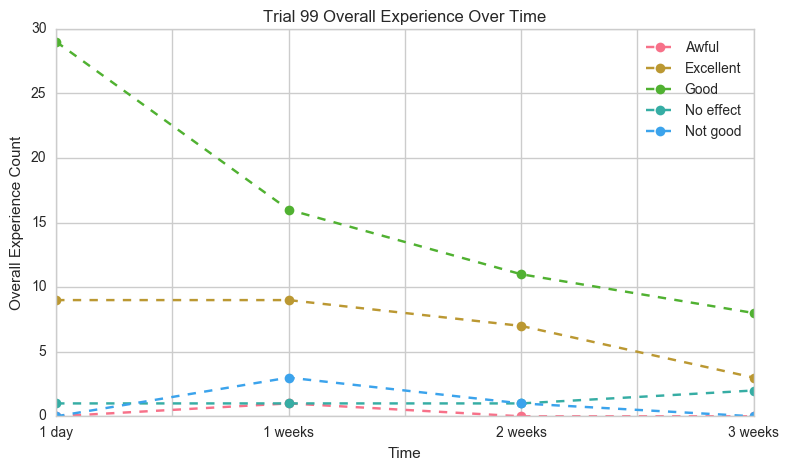

In [73]:
OE_overtime.plot(marker='o', figsize=(9,5), linestyle='--', )
plt.title('Trial 99 Overall Experience Over Time')
plt.xlabel('Time')
plt.ylabel('Overall Experience Count')
plt.legend()

2x2 contingency table between non-users and users that are likely to give a high or low rating.


The sample was grouped by the times the survey answers were collected at 1 day, 1 week, 2 week, 3 week. For each point of time, the data was then grouped by whether or not the user has tried the nootropic. This way, for each time point the data is independent. 

$H_{o}$ : There is no association between a user's status (if they are a nootropic user or not) and the overall experience rating they will likely give. 

$H_{A}$ : There is an association between a user's status and their overall experience rating. 


In [82]:
#mapping the Overall experience column by binary values of high or low rating given. 
rating = {'Excellent': 'High',
          'Good':'High',
          'No effect': 'Low',
          'Not good':'Low',
          'Awful': "Low"}

In [87]:
df_99['Overall_Exp_Rating'] = df_99['Overall_Experience'].map(rating)

day1 = df_99[df_99.Version_Duration=='1 day']
pd.crosstab(index=day1.Overall_Exp_Rating, columns=day1.User_Status, margins=True)
# so weird that there are only 38 total responses when there should be 39. 

User_Status,Non-user,XNootropic User,All
Overall_Exp_Rating,,,
High,14,24,38
All,14,24,38


In [91]:
df_99.Version_Duration.value_counts()

1 day      39
1 weeks    30
2 weeks    20
3 weeks    13
Name: Version_Duration, dtype: int64

In [92]:
day1.Version_Duration.value_counts()

1 day    39
Name: Version_Duration, dtype: int64

In [93]:
day1.User_Status.value_counts()

XNootropic User    24
Non-user           14
Name: User_Status, dtype: int64

In [94]:
day1[day1.Overall_Experience=='No effect'] # this is the user that did not respond to if they are a user or not

,Start_Date,End_Date,Last_Name,Version_Duration,Sleep_Quality,Overall_Experience,Focus_Atten_Concen,Memory,Drive_Passion_Motivation,Physical_Energy,...,Creativity_Insight,InterpersonalCapability_Empathy,Emotional_Stability,Euhphoria_Joy_Happiness,Estimated_Effect_Duration,Upper_Effect_Duration,Lower_Effect_Duration,Current_User_Comparison,User_Status,Overall_Exp_Rating
59,2017-11-01 12:21:00,2017-11-01 12:26:00,User24,1 day,OK,No effect,No effect,No effect,No effect,Less good,...,No effect,No effect,No effect,No effect,<2,2.0,0.0,NaN,NaN,Low


Because the sample between the placebo group and the drug group are different, the samples are independent because the measurements are from different people.

However, the measurements within the sample are not independent though. 

$\hat{p}_{1}$ = The proportion of XNootropic users that had an "Excellent" overall experience

$\hat{p}_{2}$ = The proportion of Non-users that had an "Excellent" overall experience


$H_{o}$ : $\hat{p}_{1} = \hat{p}_{2}$ or $\hat{p}_{1} - \hat{p}_{2}$ = 0

$H_{A}$ : $\hat{p}_{1} > \hat{p}_{2}$



In [6]:
def twoporZtest (x1,x2, n1, n2):
    p1 = x1 / n1
    p2 = x2 / n2
    
    p_hat = (x1 + x2) / (n1 + n2)
    SEM = np.sqrt(p_hat* (1-p_hat) * ((1/n1) + (1/n2)))
    z = (p1-p2) / SEM
    p_val = stats.norm.sf(abs(z))
    diff_prop = p1-p2
    m = 1.96 * np.sqrt(  ((p1 * (1-p1))/n1)  +   ((p2 * (1-p2))/n2)    )
    CI = (diff_prop - m), (diff_prop + m)
    
    print ("z: {}".format(z))
    print ("p-value: {}".format(p_val))
    print ("CI: {}".format(CI))
    print ("proportion difference: {}".format(diff_prop))
    print ("p1: {}".format(p1))
    print ("p2: {}".format(p2))


In [7]:
x1 = T99_cont_table1.loc['Excellent', 'XNootropic User']
n1 = T99_cont_table1.loc['All','XNootropic User']
p1 = x1 / n1
p1 * 100

36.507936507936506

In [8]:
x2 = T99_cont_table1.loc['Excellent', 'Non-user']
n2 = T99_cont_table1.loc['All','Non-user']
p2 = x2 / n2
p2 * 100

13.513513513513514

In [9]:
p_hat = (x1 + x2) / (n1 + n2)
SEM = np.sqrt(p_hat* (1-p_hat) * ((1/n1) + (1/n2)))
z = (p1-p2) / SEM
z

2.472568824074886

In [10]:
p_val = stats.norm.sf(abs(z))
p_val

0.0067072940561066427

In [11]:
diff_prop = p1-p2
diff_prop

0.22994422994422992

In [12]:
m = 1.96 * np.sqrt(  ((p1 * (1-p1))/n1)  +   ((p2 * (1-p2))/n2)    )
CI = (diff_prop - m), (diff_prop + m)
CI

(0.067866864751010919, 0.39202159513744894)

## Trial 51:


$\hat{p}_{1}$ = The proportion of XNootropic users that had an "Excellent" overall experience

$\hat{p}_{2}$ = The proportion of Non-users that had an "Excellent" overall experience


$H_{o}$ : $\hat{p}_{1} = \hat{p}_{2}$ or $\hat{p}_{1} - \hat{p}_{2}$ = 0

$H_{A}$ : $\hat{p}_{1} > \hat{p}_{2}$


In [13]:
T51_cont_table1 = pd.crosstab(index=df_51.Overall_Experience, columns=df_51.User_Status, margins=True)
T51_cont_table1

User_Status,Non-user,XNootropic User,All
Overall_Experience,,,
Awful,2,2,4
Excellent,7,42,49
Good,18,49,67
No effect,2,2,4
Not good,1,1,2
All,30,96,126


In [14]:
twoporZtest(42, 7, 96, 30)

z: 2.00227143742
p-value: 0.022627773093
CI: (0.023182772131770252, 0.3851505612015631)
proportion difference: 0.204166666667
p1: 0.4375
p2: 0.233333333333


## Comparing between the two trials


$\hat{p}_{1}$ = The proportion of Trial 99 users that had an "Excellent" overall experience

$\hat{p}_{2}$ = The proportion of Trial 51 that had an "Excellent" overall experience


$H_{o}$ : $\hat{p}_{1} = \hat{p}_{2}$ or $\hat{p}_{1} - \hat{p}_{2}$ = 0

$H_{A}$ : $\hat{p}_{1} > \hat{p}_{2}$


In [15]:
twoporZtest(28, 49, 100, 126)

z: -1.71547566449
p-value: 0.0431290266869
CI: (-0.23132451191812381, 0.013546734140346087)
proportion difference: -0.108888888889
p1: 0.28
p2: 0.388888888889


In [16]:
df_99.head(10)

,Start_Date,End_Date,Last_Name,Version_Duration,Sleep_Quality,Overall_Experience,Focus_Atten_Concen,Memory,Drive_Passion_Motivation,Physical_Energy,...,Verbal_Fluency_Word_Recall,Creativity_Insight,InterpersonalCapability_Empathy,Emotional_Stability,Euhphoria_Joy_Happiness,Estimated_Effect_Duration,Upper_Effect_Duration,Lower_Effect_Duration,Current_User_Comparison,User_Status
0,2017-11-14 14:51:00,2017-11-14 14:52:00,User1,1 weeks,OK,Good,Improved,Improved,Improved,Improved,...,No effect,No effect,No effect,No effect,No effect,4-8,8.0,4.0,I am not a XNootropic user,Non-user
1,2017-11-08 14:51:00,2017-11-08 14:54:00,User1,1 day,OK,Good,Improved,No effect,No effect,Improved,...,No effect,No effect,No effect,Improved,Improved,4-8,8.0,4.0,I am not a XNootropic user,Non-user
2,2017-11-17 05:50:00,2017-11-17 05:57:00,User2,1 weeks,OK,Not good,Improved,Improved,Less good,Less good,...,Improved,Improved,Improved,No effect,No effect,8+,12.0,8.0,This is less good than XNootropic,XNootropic User
3,2017-11-14 13:40:00,2017-11-14 13:48:00,User2,1 day,OK,Excellent,Improved,Improved,Improved,Improved,...,Improved,Improved,No effect,No effect,No effect,8+,12.0,8.0,This is better than XNootropic,XNootropic User
4,2017-11-20 11:05:00,2017-11-20 11:10:00,User3,2 weeks,OK,Good,Improved,No effect,Improved,Improved,...,No effect,No effect,No effect,No effect,Improved,4-8,8.0,4.0,This is better than XNootropic,XNootropic User
5,2017-11-10 07:43:00,2017-11-10 07:51:00,User3,1 weeks,OK,Excellent,Improved,No effect,Improved,Improved,...,No effect,Improved,No effect,No effect,No effect,4-8,8.0,4.0,This is better than XNootropic,XNootropic User
6,2017-11-01 20:48:00,2017-11-01 20:55:00,User3,1 day,OK,Good,Improved,No effect,Improved,Improved,...,No effect,No effect,No effect,No effect,Improved,4-8,8.0,4.0,This is better than XNootropic,XNootropic User
7,2017-11-12 12:31:00,2017-11-12 12:33:00,User4,2 weeks,Excellent,Excellent,Improved,No effect,Improved,Improved,...,No effect,Improved,Improved,Improved,No effect,4-8,8.0,4.0,This is better than XNootropic,XNootropic User
8,2017-11-09 01:23:00,2017-11-09 01:30:00,User4,1 weeks,Excellent,Excellent,Improved,No effect,Improved,Improved,...,Improved,Improved,Improved,Improved,Improved,8+,12.0,8.0,This is better than XNootropic,XNootropic User
9,2017-11-09 01:21:00,2017-11-09 01:23:00,User4,1 day,Excellent,Good,Improved,No effect,Improved,Improved,...,No effect,Improved,Improved,Improved,Improved,NaN,NaN,NaN,This is better than XNootropic,XNootropic User
